# PINN with `DeepXDE`

- https://github.com/lululxvi/deepxde

## Problem setup

We will solve a Poisson equation:
$$
\nabla^2 u = 2, \qquad x \in [-1, 1]
$$
with the Neumann boundary condtions on the right boundary
$$
\left. \dfrac{du}{dx} \right|_{x=1} = u
$$
and Dirichlet boundary conditions on the left boundary
$$
u(-1) = 0.
$$

The exact solution is $u(x) = (x+1)^2$

## Implementation

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [ ]:
geom = dde.geometry.Interval(-1, 1)

In [ ]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - 2

In [ ]:
def boundary_r(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1)

def boundary_l(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], -1)

In [ ]:
def true_solution(x):
    return (x+1)**2

In [ ]:
bc_r = dde.icbc.RobinBC(geom, lambda x, y: y, boundary_r)
bc_l = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_l)

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_r, bc_l],
                    num_domain=16,
                    num_boundary=2,
                    solution=true_solution,
                    num_test=100)

In [ ]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.776329 s



Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.99e+00, 1.13e-03, 5.77e-03]    [4.00e+00, 1.13e-03, 5.77e-03]    [9.83e-01]    


/home/mgj/workspace/DL-KHU/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [7.93e-05, 2.52e-04, 1.97e-04]    [9.22e-05, 2.52e-04, 1.97e-04]    [5.52e-03]    
2000      [3.44e-05, 3.86e-06, 2.08e-04]    [4.14e-05, 3.86e-06, 2.08e-04]    [4.51e-03]    
3000      [1.36e-05, 9.05e-06, 1.70e-07]    [1.22e-05, 9.05e-06, 1.70e-07]    [8.16e-04]    
4000      [4.04e-05, 8.42e-05, 3.00e-05]    [3.25e-05, 8.42e-05, 3.00e-05]    [2.64e-03]    
5000      [5.39e-06, 1.65e-07, 6.70e-09]    [7.00e-06, 1.65e-07, 6.70e-09]    [2.33e-04]    
6000      [5.61e-06, 1.92e-06, 1.69e-07]    [7.83e-06, 1.92e-06, 1.69e-07]    [1.47e-04]    
7000      [9.75e-06, 1.24e-05, 1.02e-06]    [8.63e-06, 1.24e-05, 1.02e-06]    [1.15e-03]    
8000      [4.63e-06, 4.10e-07, 2.10e-06]    [5.64e-06, 4.10e-07, 2.10e-06]    [4.07e-04]    
9000      [4.24e-06, 2.43e-08, 2.39e-08]    [5.12e-06, 2.43e-08, 2.39e-08]    [2.72e-04]    
10000     [8.38e-05, 2.26e-04, 3.07e-05]    [9.55e-05, 2.26e-04, 3.07e-05]    [3.61e-03]    

Best model at step 9000:
  train loss: 4.29e-06
  test loss: 5.17e-06

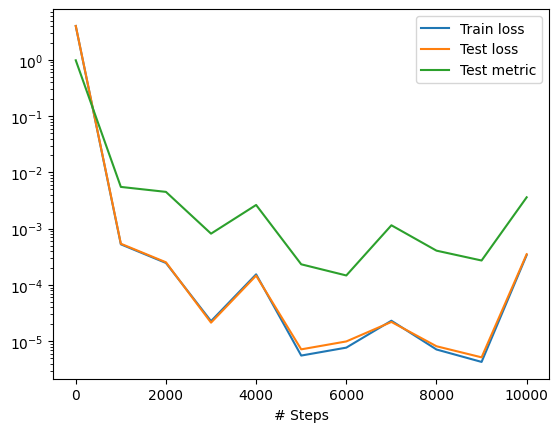

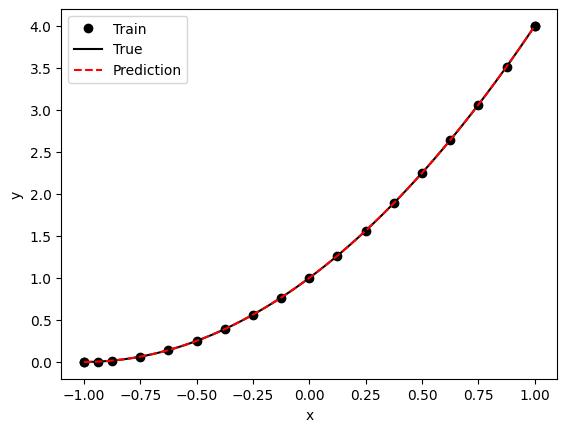

In [ ]:
loss_histroy, train_state = model.train(iterations=int(1e4))
dde.saveplot(loss_histroy, train_state, issave=False, isplot=True)